In [1]:
import pandas as pd
from matplotlib import pyplot as plt
#!pip install pivottablejs
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
lpop = pd.read_stata('ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta',convert_categoricals=False)
gpt = pd.read_csv('respuestas_gpt35_turbo')
cohere = pd.read_csv('respuestas_cohere.csv')
bard = pd.read_csv('respuestas_bard.csv')

In [3]:
# Crea un StataReader para leer los metadatos
reader = pd.io.stata.StataReader('ARG_2021_LAPOP_AmericasBarometer_v1.2_w.dta')

In [4]:
import pickle
with open(r"respuestas.pickle", "rb") as input_file:
    respuestas = pickle.load(input_file)
with open(r"preguntas_seleccionadas.pickle", "rb") as input_file:
    preguntas_seleccionadas = pickle.load(input_file)

In [5]:
lpop = lpop.drop('a4', axis=1)

In [22]:
lpop = lpop.drop('DST1BN'.lower(), axis=1)

In [23]:
lpop = lpop.drop('DRK1C'.lower(), axis=1)

In [6]:
import math
def calculate_distance(responde,llm):    
    result = 0
    num_pregs = 0
    for pregunta in list(preguntas_seleccionadas.keys()):
        if((pregunta.lower() in responde.keys()) and (not math.isnan(responde[pregunta.lower()])) and (pregunta in list(llm['Pregunta'])) 
           and(llm[llm['Pregunta']== pregunta]['Respuesta'].values[0] < 10) ):
            
            result = result + (abs(responde[pregunta.lower()]-llm[llm['Pregunta']== pregunta]['Respuesta'].values[0]))
            num_pregs = num_pregs + 1
    if(num_pregs == 0):
        result = -1
        norm_result = -1
    else:
        norm_result = result/num_pregs
    
    return(result, num_pregs, norm_result)
calculate_distance(lpop.loc[0],bard)

(30.0, 17, 1.7647058823529411)

In [24]:
lpop['gpt_results'] = lpop.apply(lambda x: calculate_distance(x, gpt), axis=1)
lpop[['gpt_distance', 'gpt_num_preg','gpt_distance_norm']] = pd.DataFrame(lpop['gpt_results'].tolist(), index=lpop.index)

In [25]:
lpop['bard_results'] = lpop.apply(lambda x: calculate_distance(x, bard), axis=1)
lpop[['bard_distance', 'bard_num_preg','bard_distance_norm']] = pd.DataFrame(lpop['bard_results'].tolist(), index=lpop.index)

In [26]:
lpop['cohere_results'] = lpop.apply(lambda x: calculate_distance(x, cohere), axis=1)
lpop[['cohere_distance', 'cohere_num_preg', 'cohere_distance_norm']] = pd.DataFrame(lpop['cohere_results'].tolist(), index=lpop.index)

In [13]:
preguntas_seleccionadas['etid']

KeyError: 'etid'

In [16]:
reader.value_labels()['ur1new_esp']

{1: 'Una ciudad',
 2: 'En la periferia o alrededores de una ciudad',
 3: 'En un pueblo/poblado cercano a una zona/área rural',
 4: 'En un área/zona rural',
 2147483622: 'No sabe',
 2147483623: 'No responde'}

In [35]:
lpop_distances['q2'.lower()].value_counts()

40    47
32    42
47    41
30    38
50    37
      ..
80     3
69     3
85     2
79     2
83     1
Name: q2, Length: 66, dtype: int64

In [41]:
 reader.variable_labels()['ing4']

'La democracia es mejor que cualquier otra forma de gobierno'

In [38]:
lpop['q10newt'] = lpop['q10newt'].replace(171, 1)
lpop['q10newt'] = lpop['q10newt'].replace(172, 2)
lpop['q10newt'] = lpop['q10newt'].replace(173, 3)
lpop['q10newt'] = lpop['q10newt'].replace(174, 4)
lpop['q10newt'] = lpop['q10newt'].replace(175, 5)

In [27]:
lpop[(lpop['bard_num_preg'] >5)&(lpop['gpt_num_preg'] >5)&(lpop['cohere_num_preg'] >5)].to_csv('lpop_distances.csv')

In [10]:
lpop_distances = lpop[lpop['bard_num_preg'] >5]

In [73]:
pregs = [p.lower() for p in preguntas_seleccionadas.keys() if p.lower() in lpop.columns]


In [15]:
lpop_distances['q10newt'].value_counts()

Series([], Name: q10newt, dtype: int64)

In [31]:
lpop_distances = lpop[(lpop['bard_num_preg'] >5)&(lpop['gpt_num_preg'] >5)&(lpop['cohere_num_preg'] >5)]

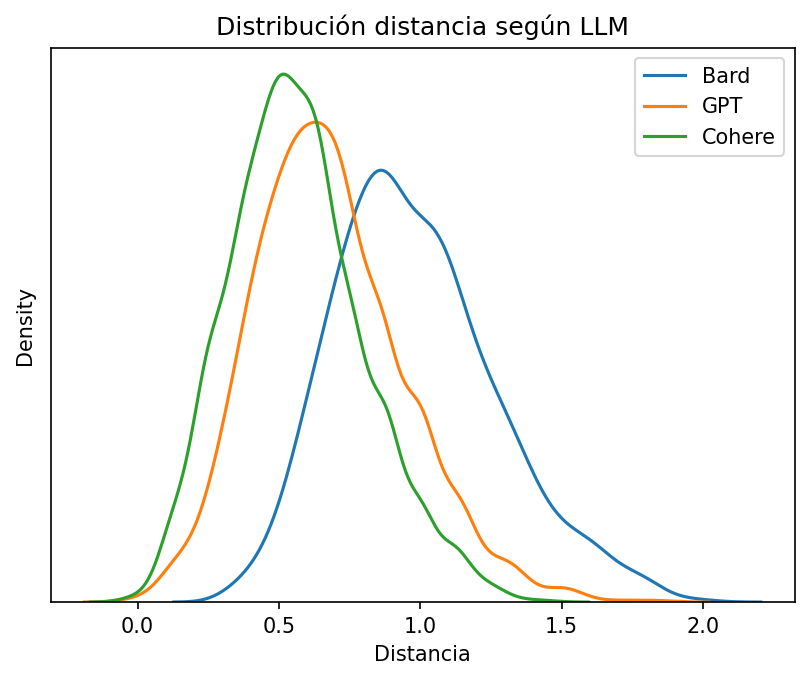

In [32]:

plt.figure(dpi=150)

sns.kdeplot(
   lpop_distances['bard_distance_norm'], label="Bard"
)
sns.kdeplot(
   lpop_distances['gpt_distance_norm'], label="GPT"
)
sns.kdeplot(
   lpop_distances['cohere_distance_norm'], label="Cohere"
)
plt.title("Distribución distancia según LLM")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

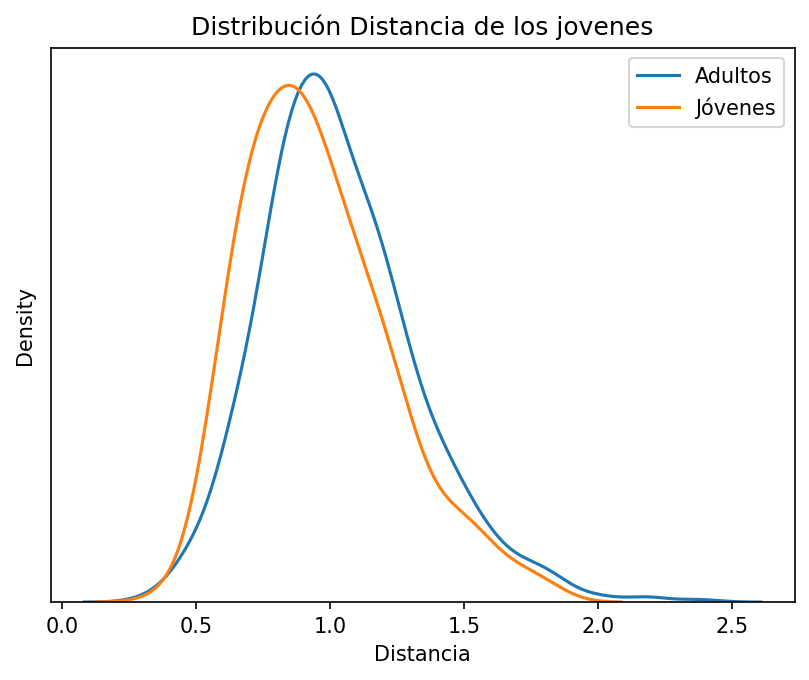

In [38]:

lpop_adulto = lpop_distances[lpop_distances['q2']>40]
lpop_joven = lpop_distances[lpop_distances['q2']<25]
plt.figure(dpi=150)

sns.kdeplot(
   lpop_adulto['bard_distance_norm'], label="Adultos"
)
sns.kdeplot(
   lpop_joven['bard_distance_norm'], label="Jóvenes"
)
plt.title("Distribución Distancia de los jovenes")
plt.xlabel("Distancia")
plt.yticks([], [])
plt.legend(loc='upper right')
plt.show()

In [31]:
pregs = [p.lower() for p in preguntas_seleccionadas.keys() if p.lower() in lpop.columns]

In [33]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows
lpop = lpop.sort_values(by='bard_distance_norm', ascending=True)

# 2. Calcular el número de filas que representa el 10%
num_rows_10_percent = int(len(lpop) * 0.1)

# 3. Seleccionar las primeras filas correspondientes al 10%
lpop[(lpop['bard_num_preg']>5)].head(num_rows_10_percent)[pregs]

,jc13,jc13covid,jc15a,jccov1,jccov2,countfair1,countfair2,countfair3,countfair4,wvsi2,wvsi3,chm1bn,chm2bn,cses6n,b2,b3,b6,dst1bn,drk1c,m1,ing4,anestg,mil10a,mil10e,ccch1,ccus1,ccch3,ccus3,ctaware,ctspecific1,ctdiffuse1,ctdiffuse2
2714,NaN,2.0,2.0,2.0,NaN,NaN,NaN,3.0,2.0,NaN,1.0,1.0,NaN,4.0,3.0,5.0,4.0,1.0,3.0,3.0,5.0,2.0,3.0,2.0,1.0,NaN,3.0,NaN,2.0,2.0,4.0,4.0
2278,2.0,NaN,2.0,1.0,NaN,NaN,NaN,3.0,2.0,NaN,2.0,NaN,1.0,4.0,6.0,5.0,5.0,2.0,3.0,3.0,5.0,2.0,2.0,3.0,2.0,NaN,1.0,NaN,2.0,4.0,2.0,4.0
2113,2.0,NaN,2.0,NaN,2.0,NaN,NaN,1.0,2.0,2.0,NaN,NaN,NaN,3.0,7.0,5.0,5.0,1.0,3.0,3.0,7.0,2.0,NaN,NaN,NaN,1.0,NaN,3.0,2.0,3.0,2.0,4.0
826,2.0,NaN,2.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,1.0,1.0,NaN,2.0,5.0,3.0,5.0,2.0,4.0,3.0,6.0,2.0,NaN,NaN,2.0,NaN,3.0,NaN,3.0,4.0,4.0,4.0
2773,2.0,NaN,2.0,2.0,NaN,3.0,2.0,NaN,NaN,1.0,NaN,NaN,2.0,5.0,5.0,5.0,5.0,3.0,3.0,2.0,6.0,2.0,2.0,2.0,2.0,NaN,1.0,NaN,2.0,2.0,2.0,5.0
2912,2.0,NaN,2.0,1.0,NaN,NaN,NaN,3.0,2.0,NaN,2.0,1.0,NaN,2.0,5.0,4.0,5.0,2.0,3.0,2.0,7.0,2.0,2.0,2.0,1.0,NaN,1.0,NaN,2.0,3.0,4.0,4.0
286,NaN,2.0,2.0,NaN,2.0,NaN,NaN,2.0,2.0,1.0,NaN,2.0,NaN,3.0,6.0,3.0,5.0,2.0,3.0,2.0,6.0,2.0,2.0,2.0,NaN,1.0,NaN,3.0,2.0,2.0,2.0,4.0
1850,NaN,2.0,2.0,NaN,2.0,2.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,3.0,5.0,4.0,6.0,2.0,2.0,2.0,5.0,2.0,NaN,1.0,2.0,NaN,1.0,NaN,2.0,2.0,2.0,4.0
1356,2.0,NaN,2.0,2.0,NaN,1.0,2.0,NaN,NaN,1.0,NaN,2.0,NaN,3.0,5.0,4.0,5.0,1.0,2.0,4.0,6.0,3.0,NaN,3.0,2.0,NaN,2.0,NaN,3.0,NaN,4.0,4.0
792,NaN,2.0,2.0,NaN,2.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,4.0,7.0,5.0,5.0,3.0,3.0,3.0,5.0,2.0,NaN,3.0,NaN,2.0,NaN,3.0,2.0,NaN,3.0,4.0
